# Visualization of a Simple Stochastic Gradient Descent (eager execution)

Here we visualize the minimization of the loss with the SGD algorithm in its variants vanilla SGD, batch SGD and minibatch SGD. For this we consider a linear model with only one weight and one bias (the slope and the offset).

> (!!!) We use here the kernel `miniconda-sumsch`.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# This needs to be run before running any tensorflow function
tf.enable_eager_execution()

In [3]:
tf.VERSION

'1.12.0'

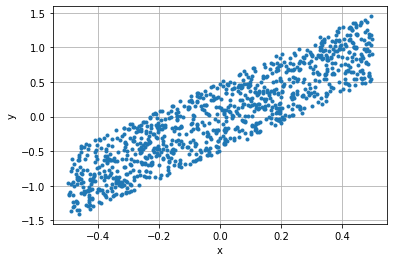

In [4]:
# Create a linear function with noise as our data
nsamples = 1000
ref_slope = 2.0
ref_offset = 0.0
noise = np.random.random((nsamples, 1)) - 0.5    # -0.5 to center the noise
x_train = np.random.random((nsamples, 1)) - 0.5  # -0.5 to center x around 0
y_train = ref_slope * x_train + ref_offset + noise

plt.plot(x_train, y_train, '.')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

### 1. Create a dataset object and define an input pipeline with the `tf.data` API.

Within Eager Execution, the `tf.data.Dataset` object is an iterable. There is no need to define an iterator.

In [5]:
dataset = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32),
                                              y_train.astype(np.float32)))
dataset = dataset.batch(1000)    # Set a batch size. Now iterating over the dataset will be in batches of 1000 samples.
dataset = dataset.repeat(100)    # Iterate 100 times over the dataset.

### 2. Define the model

Here we should define the model. However, since this example is intended to be very simple, we will defined inside of the
training. This is because in Eager Model, we will need to create a list of the model variables to compute the gradients to.
On the tutorial with TensorFlow-2.0 we will see how to do it properly.

So, let's just define the variables of the model and the optimizer. Within Eager Execution there's no need to initialize the model variabes.

In [6]:
slope = tf.Variable(np.random.randn(), name='slope')
offset = tf.Variable(np.random.randn(), name='offset')

opt = tf.train.GradientDescentOptimizer(learning_rate=0.5)

### 3. Training

Within Eager Execution the training is composed by:
 * Iterating over the dataset.
 * Running the training operations inside a `with tf.GradientTape()`.
 * Computing the Gradients for each batch.

In [7]:
history = []

for xtr, ytr in dataset:
    with tf.GradientTape() as tape:
        # We define the model and the loss now
        yhat = slope * xtr + offset
        loss = tf.losses.mean_squared_error(yhat, ytr)
        
    grads = tape.gradient(loss, [slope, offset])
    opt.apply_gradients(zip(grads, [slope, offset]))
    
    history.append([slope.numpy(), offset.numpy(), loss.numpy()])

### Some plots

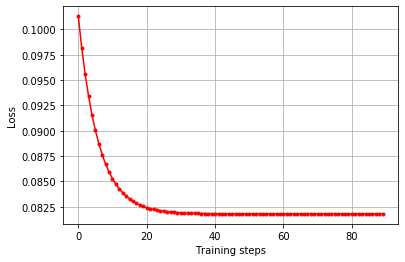

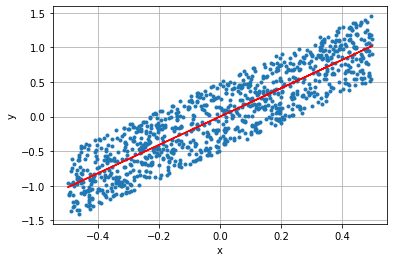

In [8]:
slope_hist = np.array(history)[:, 0]
offset_hist = np.array(history)[:, 1]
loss_hist = np.array(history)[:, 2]

plt.plot(loss_hist[10:], 'r.-')
plt.xlabel('Training steps')
plt.ylabel('Loss')
plt.grid()
plt.show()

plt.plot(x_train, y_train, '.')
plt.plot(x_train, slope_hist[-1] * x_train + offset_hist[-1], 'r-')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

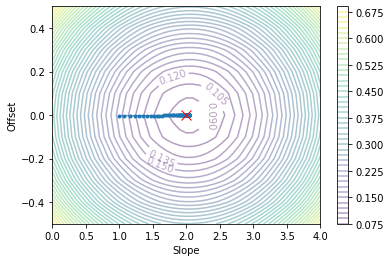

In [9]:
def loss_function_field(m, n, xref, yref):
    return np.mean(np.square(yref - m * xref - n ))

_m = np.arange(-0, 4.01, 0.1)
_n = np.arange(-0.5, 0.51, 0.1)
M, N = np.meshgrid(_m, _n)

Z = np.zeros(M.shape)
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        Z[i, j] = loss_function_field(M[i, j], N[i, j],
                                      x_train, y_train)
        
#matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

cp = plt.contour(M, N, Z, 50, vmin=Z.min(), vmax=Z.max(), alpha=0.4)
plt.clabel(cp, cp.levels[:6])
plt.colorbar()
m = slope_hist[-1]
n = offset_hist[-1]
plt.plot(slope_hist, offset_hist, '.-', lw=1)
plt.plot([ref_slope], [ref_offset], 'rx', ms=10)
plt.xlim([_m.min(), _m.max()])
plt.ylim([_n.min(), _n.max()])
plt.xlabel('Slope')
plt.ylabel('Offset')
plt.show()

#matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)